<h2>Test for CUDA</h2>

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available. Training on CPU...")
else:
  print("CUDA is available! Training on GPU...")

CUDA is available! Training on GPU...


<h2>Load and Augment the Data : Cifar-10</h2>

In [2]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)

test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 86288781.42it/s]                               


Files already downloaded and verified


In [0]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)

valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         num_workers=num_workers)

In [0]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck']

<h2>Visualize a Batch of Training data</h2>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img = img/2+0.5 #unormalize
  plt.imshow(np.transpose(img,(1,2,0))) # convert from tensor image  

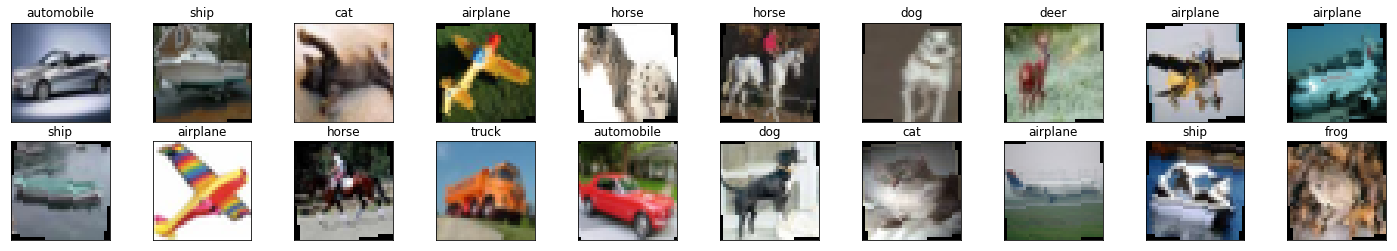

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))

for idx in range(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

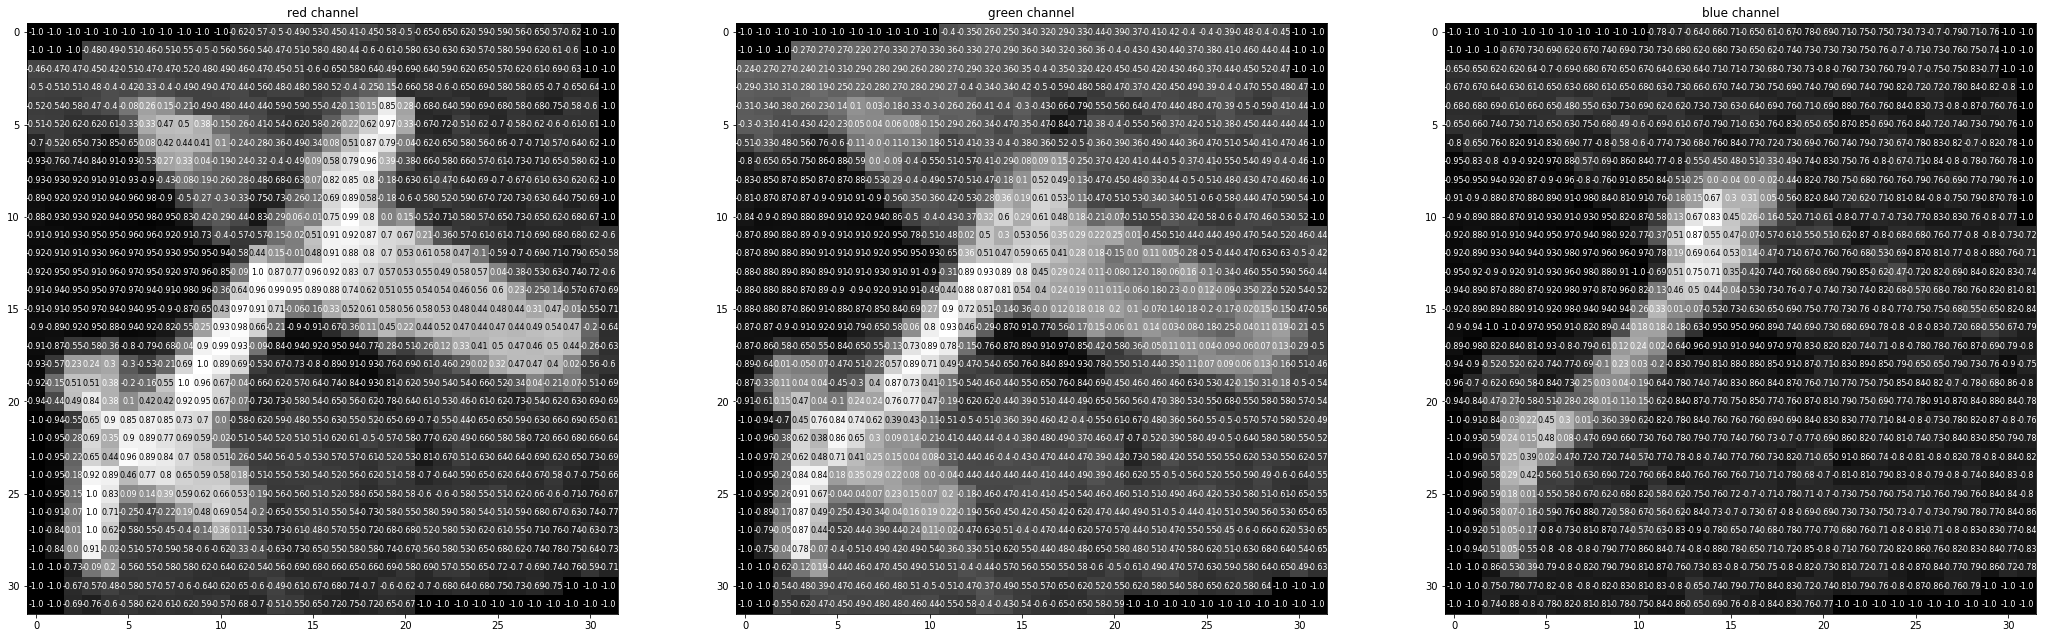

In [14]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

<h2>Define Model Architecture</h2>

In [0]:
from torch import nn
import torch.nn.functional as F

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


<h2>Define a loss function and optimizer</h2>

In [0]:
import torch.optim as optim

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

<h2>Train Neural Net</h2>

In [30]:
epochs = 30

valid_loss_min = np.Inf

for e in range(1, epochs+1):
  train_loss = 0.0
  valid_loss = 0.0
  
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
      
    optimizer.zero_grad()
    
    output = model(data)
    
    loss = criterion(output, target)
    
    loss.backward()
    
    optimizer.step()
    
    train_loss+=loss.item()*data.size(0)
    
  model.eval()
    
  for batch_idx, (data, target) in enumerate(valid_loader):
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
      
      output = model(data)
      
      loss = criterion(output, target)
      
      valid_loss+=loss.item()*data.size(0)
      
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
  
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, valid_loss))
    
    # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,valid_loss))
    torch.save(model.state_dict(), 'model_augmented.pt')
    valid_loss_min = valid_loss
  

Epoch: 1 	Training Loss: 1.665492 	Validation Loss: 1.318710
Validation loss decreased (inf --> 1.318710).  Saving model ...
Epoch: 2 	Training Loss: 1.290032 	Validation Loss: 1.197446
Validation loss decreased (1.318710 --> 1.197446).  Saving model ...
Epoch: 3 	Training Loss: 1.179657 	Validation Loss: 1.058489
Validation loss decreased (1.197446 --> 1.058489).  Saving model ...
Epoch: 4 	Training Loss: 1.112268 	Validation Loss: 1.034449
Validation loss decreased (1.058489 --> 1.034449).  Saving model ...
Epoch: 5 	Training Loss: 1.085543 	Validation Loss: 0.985324
Validation loss decreased (1.034449 --> 0.985324).  Saving model ...
Epoch: 6 	Training Loss: 1.060202 	Validation Loss: 0.976244
Validation loss decreased (0.985324 --> 0.976244).  Saving model ...
Epoch: 7 	Training Loss: 1.045277 	Validation Loss: 1.020708
Epoch: 8 	Training Loss: 1.027408 	Validation Loss: 0.995667
Epoch: 9 	Training Loss: 1.016891 	Validation Loss: 0.973796
Validation loss decreased (0.976244 --> 0.

<h2>Load Model with the Lowest Validation</h2>

In [31]:
model.load_state_dict(torch.load('model_augmented.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

<h2>Test the Trained Network
</h2>

In [33]:
test_loss = 0.0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for batch_idx, (data, target) in enumerate(test_loader):
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  
  output = model(data)
  
  loss = criterion(output, target)
  
  test_loss+=loss.item()*data.size(0)
  
  _, pred = torch.max(output, 1)
  
  correct_tensor = pred.eq(target.data.view_as(pred))
  
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
    
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.982354

Test Accuracy of airplane: 65% (654/1000)
Test Accuracy of automobile: 67% (674/1000)
Test Accuracy of  bird: 54% (542/1000)
Test Accuracy of   cat: 44% (442/1000)
Test Accuracy of  deer: 62% (622/1000)
Test Accuracy of   dog: 55% (559/1000)
Test Accuracy of  frog: 72% (726/1000)
Test Accuracy of horse: 75% (755/1000)
Test Accuracy of  ship: 78% (788/1000)
Test Accuracy of truck: 83% (839/1000)

Test Accuracy (Overall): 66% (6601/10000)
